### Artificial Neural Networks

This experiment will be used to train a simple neural network architecture using pytorch. This network will be trained for character recognition using the MNIST dataset where all the images have a size of 28x28. In this experiment we will consider that the input image are flattened from an array of 28x28 to a vector of 784. The neural network architecture to be used is given below, where it consists of 784 input neurons, 128 neurons in the first hidden layer, 64 neurons in the second hidden layer and ten neurons in the output layer.

![Simple Neural Network Architecture](https://miro.medium.com/max/2400/1*HWhBextdDSkxYvz0kEMTVg.png)

Check if we have a GPU to be used, otherwise use CPU

In [1]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


We start by defining a network class as shown in the following cell.

In [2]:
from torch import nn
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(64, 10)

        # Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)

        return x

Let’s go through this line by line.

```python
class Network(nn.Module):
```

Here we’re inheriting from ```nn.Module```. Combined with ```super().__init__()``` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from ```nn.Module``` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden1 = nn.Linear(784, 128)
self.hidden2 = nn.Linear(128, 64)
```

This line creates a module for a linear transformation with 784 inputs and 128 outputs, followed by another hidden layer with 128 inputs and 64 outputs assigned to ```self.hidden1``` and ```self.hidden2``` respectively. The module automatically creates the weight and bias tensors which we'll use in the forward method. You can access the weight and bias tensors once the network (```net```) is created with net.hidden.weight and net.hidden.bias.

```python
self.output = nn.Linear(64, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here we defined operations for the sigmoid activation and softmax output. Setting dim=1 in ```nn.Softmax(dim=1)``` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with ```nn.Module``` must have a ```forward``` method defined. It takes in a tensor ```x``` and passes it through the operations you defined in the ```__init__``` method.

```python
x = self.hidden1(x)
x = self.hidden2(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor ```x``` is passed through each operation and reassigned to ```x```. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the ```__init__``` method doesn't matter, but you'll need to sequence the operations correctly in the forward method.

In [3]:
# Create the network and look at it's text representation
model = Network()
print(model)

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


## Building Neural Network using ```nn.Sequential```

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, ```nn.Sequential```([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build a neural network this time with two hidden layers:


In [4]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


## Training the Neural Network

First we start by downloading the MNIST dataset which will be used for both training and testing. In this experiment we will use a batch size of 64.

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)), # (img - mean) / std
                              ])
# Download and load the training data
trainset = datasets.MNIST('./Data/Training/', download=True, train=True, transform=transform)
testset  = datasets.MNIST('./Data/Testing/', download=True, train=False, transform=transform)

# Prepare the train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Now lets visualize a bit the data and see the ground truth.

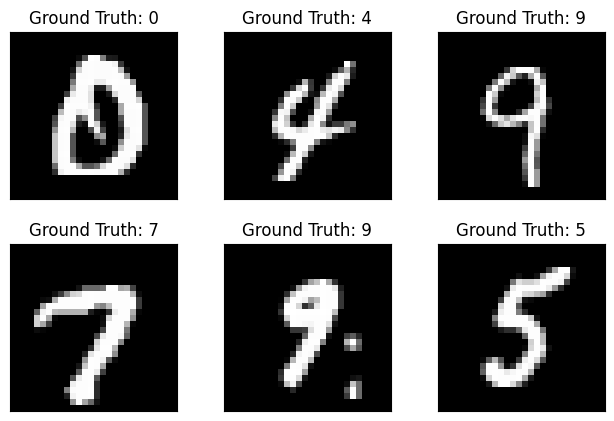

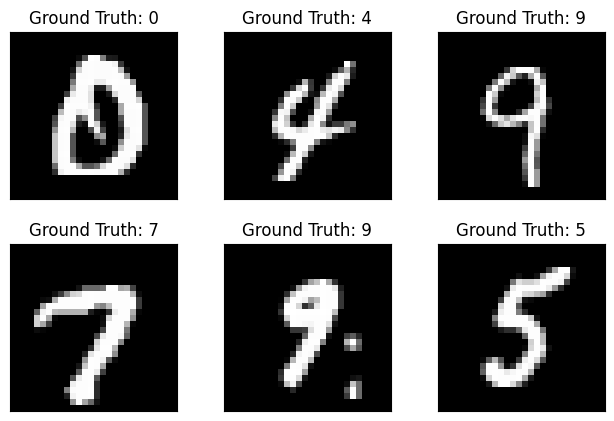

In [6]:
import matplotlib.pyplot as plt

examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Some nomenclature, one pass through the entire dataset is called an epoch. So here we’re going to loop through ```trainloader``` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights. The performance of the network is expected to improve after each epoch until it saturates. So we are going to print the training loss after each epoch.

In [7]:
import tqdm.notebook

# Defining the network to be trained
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Send the model to the device
model = model.to(device)

# Define the loss
criterion = nn.NLLLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)
epochs = 5

for e in tqdm.notebook.tqdm(range(epochs)):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

  0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 1.8532668902421556
Training loss: 0.8126696225867343
Training loss: 0.5174114844565199
Training loss: 0.42492631859362506
Training loss: 0.38129874673098135


Note: ```optimizer.zero_grad()``` : When we do multiple backwards passes with the same parameters, the gradients are accumulated. This means that we need to zero the gradients on each training pass or we'll retain gradients from previous training batches.

Now it is time to evaluate the performance on the testing data. This model achieves an accuracy of around 89-90%.

In [8]:
model.eval()
test_loss = 0
correct = 0
test_losses = []
with torch.no_grad():
    for images, target in testloader:

        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        output = model(images)

        test_loss += F.nll_loss(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]

        prediction = pred[0]

        correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

/opt/users/gpel0001/cce3207/cce3207-venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3507, Accuracy: 9008/10000 (90.08%)



Now we will evaluate the performance of the network on the testing data and use some visualization. We first plot a batch as a 8x8 grid and display the ground truth and also the predictions for the batch. We also print the accuracy of the considered batch.

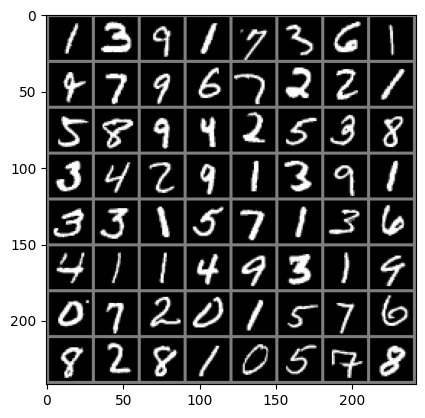

Ground-Truth
[[1 3 9 1 7 3 6 1]
 [4 7 9 6 7 2 2 1]
 [5 8 9 4 2 5 3 8]
 [3 4 2 9 1 3 9 1]
 [3 3 1 5 7 1 3 6]
 [4 1 1 4 9 3 1 9]
 [0 7 2 0 1 5 7 6]
 [8 2 8 1 0 5 7 8]]
Predicted
[[1 3 9 1 7 5 6 1]
 [9 7 9 6 7 2 2 1]
 [5 8 9 9 2 5 3 8]
 [3 4 8 9 1 3 9 1]
 [3 3 1 5 7 1 3 6]
 [4 1 1 4 9 3 1 9]
 [0 7 2 0 1 5 7 6]
 [9 2 8 1 0 5 7 8]]
Accuracy: 0.921875


In [9]:
import torchvision
import numpy as np

def imshow(img):
    img = (img * 0.5) + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))

print('Ground-Truth')
gt = np.array([int(labels[j])for j in range(64)]).reshape((8,8))
print(gt)

# Flatten MNIST images into a 784 long vector
images = images.view(images.shape[0], -1)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted')
pred = np.array([int(predicted[j])for j in range(64)]).reshape((8,8))
print(pred)

correct = np.sum(pred.flatten() == gt.flatten())
print('Accuracy: {}'.format(float(correct)/64))
